# Practical Statistics for Data Scientists (Python)
# Chapter 6. Statistical Machine Learning
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Import required Python packages.

In [2]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

no display found. Using non-interactive Agg backend


pip install xgboost

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [4]:
LOAN200_CSV = DATA / 'loan200.csv'
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

Set this if the notebook crashes in the XGBoost part.

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# K-Nearest Neighbors
## A Small Example: Predicting Loan Default

In [6]:
loan200 = pd.read_csv(LOAN200_CSV)
 
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'


newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


P note: n_neighbors=20 -> to compare the target with nearest 20 points (neighbor). In this case, 9 defaulted loans lie within the circle, as compared with 11 paid-off loans. Hence the predicted outcome of the loan is paid off. In this example, the probability of default would have been estimated at 9/20 , or 0.45.

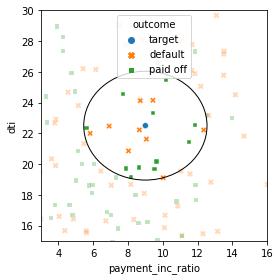

In [7]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False)
ellipse = Ellipse(xy=newloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

## Standardization (Normalization, Z-Scores)

Following the model fit, we can use the kneighbors method to identify the five closest rows in the training set with scikit-learn:

In [8]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)


predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


The value of revol_bal in these neighbors is very close to its value in the new record, but the other predictor variables are all over the map and essentially play no role in determining neighbors.

The `sklearn.preprocessing.StandardScaler` method is first trained with the predictors and is subsequently used to transform the data set prior to training the KNN model:

In [9]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


The five nearest neighbors are much more alike in all the variables, providing a more sensible result. Note that the results are displayed on the original scale, but KNN was applied to the scaled data and the new loan to be predicted.

## KNN as a Feature Engine

count    45342.000000
mean         0.501099
std          0.128735
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


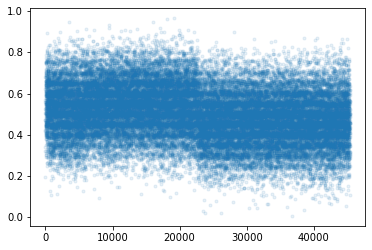

In [10]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
            alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
#P note: this is the new feature derived from KNN
print(loan_data['borrower_score'].describe())

The result is a feature that predicts the likelihood a borrower will default based on his
credit history.

# Tree Models
## A Simple Example
The package _scikit-learn_ has the class `DecisionTreeClassifier` to build a decision tree model. The function `plotDecisionTree` from the _dmba_ package can be used to visualize the tree. 

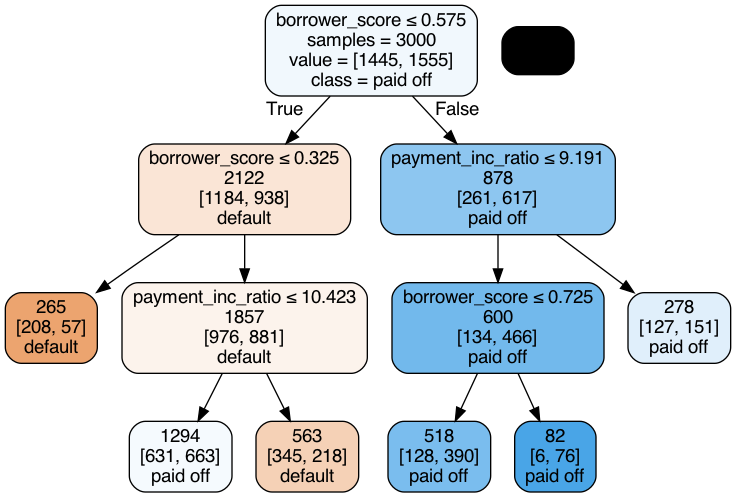

In [11]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

pip install pydotplus

after install pydotplus still meet the error: GraphViz's executables not found

-> try to solve with GraphViz installation in conda: conda install graphviz 

The scikit-learn documentation describes how to *create a text representation of a decision tree model*. We included a convenience function in our dmba package:

In [12]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


## The Recursive Partitioning Algorithm

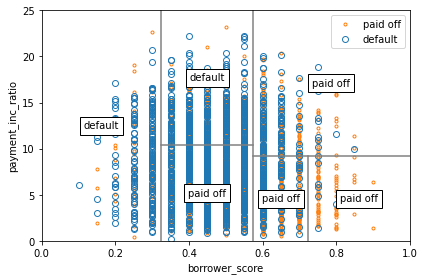

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()
plt.show()

## Measuring Homogeneity or Impurity

In [14]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

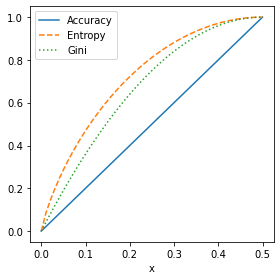

In [15]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x': x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()

# Bagging and the Random Forest
## Random Forest

In [16]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, 
                            oob_score=True)
rf.fit(X, y)
print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


The RandomForestClassifier implementation has no easy way to get out-of-bag estimates as a function of number of trees in the random forest. We can train a sequence of classifiers with an increasing number of trees and keep track of the oob_score_ values. This method is, however, not efficient:

In [17]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, 
                                criterion='entropy', max_depth=5,
                                random_state=1, oob_score=True)
    rf.fit(X, y)
    oobScores.append(rf.oob_score_)

<AxesSubplot:xlabel='n'>

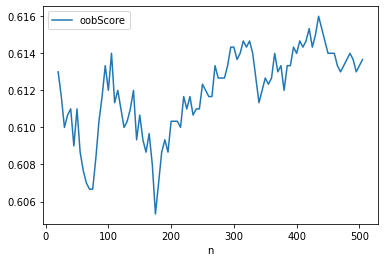

In [18]:
pd.DataFrame({
    'n': n_estimator, 
    'oobScore': oobScores
}).plot(x='n', y='oobScore')

The predicted values using Python:

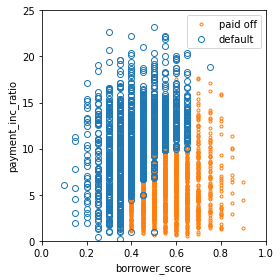

In [19]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout(   )
plt.show()

## Variable importance
This is different to R. The accuracy decrease is not available out of the box.

In [20]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                        criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


In Python, the `RandomForestClassifier` collects information about feature importance during training and makes it available with the field `feature_importances_`:

In [22]:
importances = rf_all.feature_importances_

The “Gini decrease” is available as the feature_importance_ property of the fitted classifier. Accuracy decrease, however, is not available out of the box for Python. We can calculate it (scores) using the following code:

In [23]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)
 
# crossvalidate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                          test_size=0.3)
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score:')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score:
[(0.0757, 'borrower_score'), (0.0309, 'grade'), (0.0291, 'term_60 months'), (0.0119, 'payment_inc_ratio'), (0.011, 'annual_inc'), (0.0041, 'revol_bal'), (0.0026, 'purpose_credit_card'), (0.0024, 'dti'), (0.0021, 'purpose__small_business'), (0.0019, 'open_acc'), (0.0012, 'home__OWN'), (0.001, 'purpose_small_business'), (0.001, 'loan_amnt'), (0.001, 'emp_len__ > 1 Year'), (0.0007, 'purpose__other'), (0.0005, 'delinq_2yrs_zero'), (0.0003, 'purpose_wedding'), (0.0003, 'pub_rec_zero'), (0.0002, 'purpose_vacation'), (0.0, 'purpose_other'), (0.0, 'purpose_moving'), (0.0, 'purpose_medical'), (0.0, 'purpose_major_purchase'), (-0.0, 'purpose_house'), (-0.0, 'purpose__home_improvement'), (-0.0002, 'purpose__major_purchase'), (-0.0003, 'home__RENT'), (-0.0003, 'emp_length'), (-0.0005, 'purpose__medical'), (-0.0007, 'purpose_home_improvement'), (-0.001, 'revol_util'), (-0.0015, 'purpose__debt_consolidation'), (-0.002, 'purpose_debt_consolidation')]


The result is shown in Figure 6-8. A similar graph can be created with this Python code:

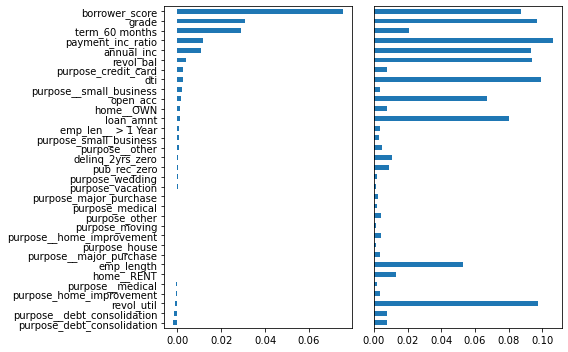

In [24]:
importances = rf_all.feature_importances_

df = pd.DataFrame({
    'feature': X.columns, 
    'Accuracy decrease': [np.mean(scores[column]) for column in 
                         X.columns],
    'Gini decrease': rf_all.feature_importances_, 
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', 
             legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', 
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

# Boosting
## XGBoost

In Python, xgboost has two different interfaces: a scikit-learn API and a more functional interface like in R. To be consistent with other scikit-learn methods, some parameters were renamed. For example, eta is renamed to learning_rate; using eta will not fail, but it will not have the desired effect:

In [25]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, 
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

/Users/WangFu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)


Predict values in Python

In [26]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.828856
1            0.40            5.43165    default      0.260156
2            0.70            9.23003    default      0.320805
3            0.40            2.33482   paid off      0.678005
4            0.45           12.10320    default      0.140204


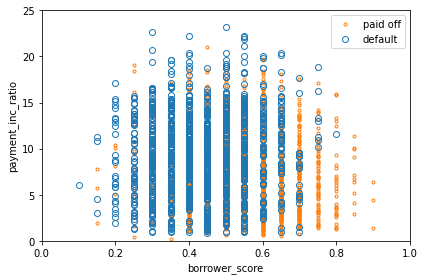

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o', 
    markerfacecolor='none', markeredgecolor='C0', ax=ax)
ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()

The result is shown in Figure 6-9. Qualitatively, this is similar to the predictions from the random forest; see Figure 6-7. The predictions are somewhat noisy in that some borrowers with a very high borrower score still end up with a prediction of default.

## Regularization: Avoiding Overfitting

Fit xgboost to the loan data for a training set with all of the variables included in the model. In Python, you can do this as follows:
We use the function `train_test_split` in Python to split the data set into training and test sets:

In [28]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]])

#split the data set into training and test sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=0, learning_rate=0.3, subsample=1,
                            use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

# P note: penalize model with reg_lambda = 1000
xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')
print(xgb_penalty.fit(train_X, train_y))

/Users/WangFu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)


In [29]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.12019693282779696
default:  0.3597
penalty:  0.3388


#From the book (the result % might be slightly different but the pattern results are the same) - P note <br>
The test set consists of 10,000 randomly sampled records from the full data, and the training set consists of the remaining records. Boosting leads to an error rate of only 13.3% for the training set. The test set, however, has a much higher error rate of 35.3%. This is a result of overfitting: while boosting can explain the variability in the training set very well, the prediction rules do not apply to new data.

To compare the in- sample versus out-of-sample error rates:

In [30]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results)
print(results.head())

/Users/WangFu/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


   iterations  default train  penalty train  default test  penalty test
0           1       0.337361       0.336285        0.3544        0.3585
1           2       0.329325       0.337530        0.3461        0.3578
2           3       0.324373       0.337559        0.3448        0.3520
3           4       0.321261       0.337927        0.3453        0.3508
4           5       0.319507       0.339030        0.3441        0.3542


We can use the pandas plot method to create the line graph. The axis returned from the first plot allows us to overlay additional lines onto the same graph. This is a pattern that many of Python’s graph packages support:

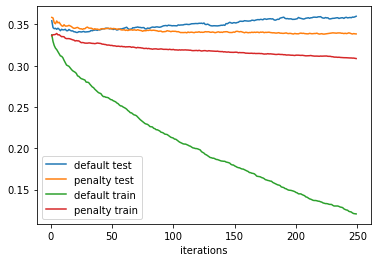

In [31]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()

## Hyperparameters and Cross-Validation

In the following Python code, we create all possible combinations of hyperparameters and fit and evaluate models with each combination:

In [32]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, 
                        max_depth=max_depth, learning_rate=eta,
                        use_label_encoder=False, eval_metric='error')
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

/Users/WangFu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.32845540244286087}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.33366367551502146}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.34246481079955693}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3412772003134769}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.3667488926132004}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3734660117095848}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.35406424263237224}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3879237958804892}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.38637604179363577}
   eta  max_depth  avg_error
0  0.1          3   0.328455
1  0.1          6   0.333664
2  0.1          9   0.342465
3  0.5          3   0.341277
4  0.5          6   0.366749
5  0.5          9   0.373466
6  0.9          3   0.354064
7  0.9          6   0.387924
8  0.9          9   0.386376


In [33]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.845540  33.366368  34.246481
0.5        34.127720  36.674889  37.346601
0.9        35.406424  38.792380  38.637604


Cross-validation suggests that using shallower trees with a smaller value of eta/learn ing_rate yields more accurate results. Since these models are also more stable, the best parameters to use are eta=0.1 and max_depth=3 (or possibly max_depth=6).